In [40]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import xarray as xr
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Polygon
import rasterio.features

## Reproject Geotiff
`!gdalwarp -t_srs EPSG:3577 'MacquarieBarwon2014_5716561_01_001.tif' 'MacquarieBarwon2014_5716561_01_0013577.tif'`

In [2]:
LiDAR = xr.open_rasterio('MacquarieBarwon2014_5716561_01_0013577.tif')

### Filter out missing values
For some reason, this GeoTiff has used a stupidly large negative number to represent missing values. We need to remove these so we can actually use the data properly.

In [3]:
LiDARFiltered = LiDAR.where(LiDAR>=-5000)
LiDARFilteredDA = xr.DataArray(LiDARFiltered.squeeze(),
                                  coords=[LiDARFiltered.y, LiDARFiltered.x],
                                  dims=['y', 'x'],
                                  name='DEM',
                                  attrs=LiDARFiltered.attrs)
LiDARFilteredDS = LiDARFilteredDA.to_dataset()

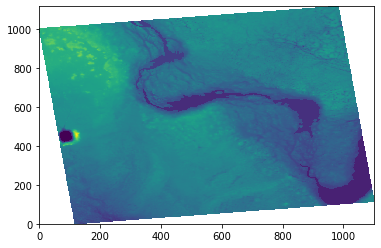

In [4]:
plt.pcolor(LiDARFilteredDS['DEM'])

## VegComm 
from https://datasets.seed.nsw.gov.au/dataset/macquarie-marshes-vegetation1991-2008-vis_id-3920ff230/resource/3f102578-05ba-4a59-854d-fddd9ab27f53

`!ogr2ogr -t_srs EPSG:3577 MacquarieMarshes_2008_E_39203577.shp MacquarieMarshes_2008_E_3920.shp`

In [5]:
VegComm = gpd.read_file('MacquarieMarshes_2008_E_39203577.shp') 

## Now we need to create a mask from the extents of the LiDAR data

In [6]:
# Grab the lat and lon extents of the LiDAR dataset
# Note that there are 5 pairs here - four corners plus back to the start
latextents=[LiDARFiltered.x.min().item(), LiDARFiltered.x.min().item(), LiDARFiltered.x.max().item(), LiDARFiltered.x.max().item(), LiDARFiltered.x.min().item()]
lonextents=[LiDARFiltered.y.max().item(), LiDARFiltered.y.min().item(), LiDARFiltered.y.min().item(), LiDARFiltered.y.max().item(), LiDARFiltered.y.max().item()]
# Turn those coordinates into a polygon
polygon_geom = Polygon(zip(latextents, lonextents))

# Create a geodataframe with just our new extent polygon
df = gpd.GeoDataFrame(gpd.GeoSeries(polygon_geom), columns=['geometry'], crs='EPSG:3577')

## Now clip the shapefile with the extents of the raster

In [7]:
ClippedVeg = gpd.clip(VegComm, df)

/usr/local/lib/python3.6/dist-packages/geopandas/geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


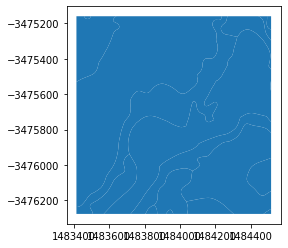

In [8]:
ClippedVeg.plot()

### Assign a random UID for each species

In [102]:
ClippedVeg['RandomUID'] = ClippedVeg.groupby('Species_1').ngroup()

unique_combinations = ClippedVeg[['RandomUID', 'Species_1']].drop_duplicates()
SpeciesDict = dict(zip(unique_combinations.RandomUID, unique_combinations.Species_1))

### Rasterize the shapefile

In [34]:
shapes = zip(ClippedVeg['geometry'], ClippedVeg['RandomUID'])
# First grab the spatial information from our datacube xarray object
transform = LiDARFiltered.attrs['transform']
y, x = LiDARFiltered.squeeze().values.shape

# Now convert the polgons into a numpy array
RasterVeg = rasterio.features.rasterize(shapes=shapes,
                                                 out_shape=(y, x),
                                                 all_touched=False,
                                                 fill=np.nan,
                                                 transform=transform)

# Convert result to a xarray.DataArray using coords etc from original dc.load dataset
RasterVeg = xr.DataArray(RasterVeg,
                                  coords=[LiDARFiltered.y, LiDARFiltered.x],
                                  dims=['y', 'x'],
                                  name='veg_randomUID',
                                  attrs=LiDARFiltered.attrs)

# Convert to xarray dataset to assist with writing to GeoTIFF
RasterVeg = RasterVeg.to_dataset()
RasterVeg.attrs = LiDARFiltered.attrs

In [35]:
CombineLiDARVeg = RasterVeg.merge(LiDARFilteredDS)

Text(0, 0.5, 'Elevation (masl)')

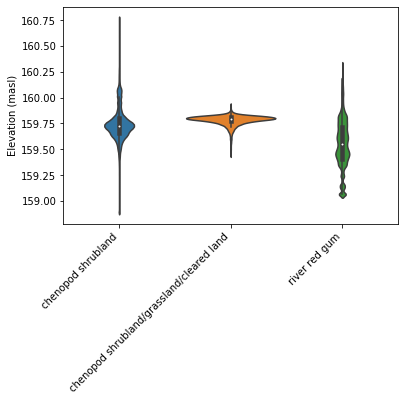

In [121]:
ax = sns.violinplot(x=CombineLiDARVeg['veg_randomUID'].values.flatten(), y=CombineLiDARVeg['DEM'].values.flatten())
ax.set_xticklabels(sorted(SpeciesDict.values()), rotation=45, ha='right');
plt.ylabel('Elevation (masl)')